## Basic QPE
- This is an implementation of the vanilla QPE circuit 
- It tries to generalize the circuit for an arbitrary precision circuit returned to the user
- Requirements are the Unitary matrix and precision 

In [2]:
from qiskit import * 
import matplotlib.pyplot as plt 
from qiskit.extensions import UnitaryGate
from qiskit.circuit import add_control 
from qiskit.tools.visualization import plot_bloch_multivector,plot_histogram
import numpy as np 
from qiskit_textbook.tools import array_to_latex

In [16]:
class QPE():
    '''
    Implements the vanilla QPE algorithm utilising the Inverse Fourier Transform 
    and Phase Kickbacks.
    
      Attributes :
          precision : int([1,...]): precision of the phase estimation ( also equal to number of qubits in scratch register)
          unitary(np.ndarray or QuantumCircuit or UnitaryGate): unitary operator for which QPE is being applied. 
          rotations(dict): contains the rotation angles required for the IQFT procedure 
                      key : stage number, value : angle value
                  
      Methods :
          get_rotations() : generate rotation values for the implementation of Inverse QFT 
          get_QFT(n_qubits,swaps,show) : generate an n_qubit Quantum Fourier Transform 
          get_QPE(show) : generate the final QPE circuit to be attached to the user's quantum circuit 
    
    '''
    def __init__(self,precision,unitary):
        '''
        Args :
            precision(int) : The precision upto which the phase needs to be estimated. 
                             Interpreted as 2^(-precision). 
                             eg. precision = 4 means the phase is going to be precise 
                                 upto 2^(-4).
            unitary(np.ndarray or UnitaryGate or QuantumCircuit): 
                            The unitary for which we want to determine the phase. Currently 
                            this class supports 2 x 2 matrices or single qubit gates.
                            Shall be extended for higher order matrices. 
        Raises :
            TypeError : if precision or unitary are not of a valid type 
            ValueError : if precision is not valid
            Exception : if unitary is of larger size than 2 x 2  
        
        Examples :
            from basic_QPE import QPE
                # passing as ndarray
                theta = 1/5
                U1 = np.ndarray([[1,0],
                                [0, np.exp(2*np.pi*1j*(theta))]])
                qpe1 = QPE(precision = 4, unitary = U1)
                
                # passing as QuantumCircuit
                U2 = QuantumCircuit(1) 
                U2.rz(np.pi/7,0)
                qpe2 = QPE(precision = 5,unitary = U2)
            
        '''
        # handle precision
        if type(precision) != int:
            raise TypeError("Precision needs to be an integer")
        elif precision<0 or precision == 0:
            raise ValueError("Precision needs to be atleast 1")
            
        self.precision = precision 
        
        #handle unitary 
        if not isinstance(unitary,np.ndarray) and not isinstance(unitary,QuantumCircuit) and not isinstance(unitary,UnitaryGate):
            raise TypeError("A numpy array, Quantum Circuit or UnitaryGate needs to be passed as the unitary matrix")

        if isinstance(unitary,np.ndarray):
            self.unit_qubits = int(np.log2(unitary.shape[0]))
        else:
            self.unit_qubits = unitary.num_qubits 
        self.unitary = unitary 
        self.rotations = self.get_rotations()
        
        
    def get_rotations(self):
        '''Returns a dictionary of the angles associated with 
           each rotation gate upto precision specified '''
        rots = {}
        for k in range(1,self.precision):
            rots[k] = np.pi/(2**k)
        return rots 

    
    def get_QFT(self,n_qubits :int ,show = False,swaps = True):
        '''Returns an n_qubits QFT circuit 
        
         Arguments :
             n_qubits : the number of qubits 
             show : whether to draw the circuit 
             swaps : whether swaps need to be performed at the 
                     end of the procedure 
           
         Returns :
             QuantumCircuit : the QuantumCircuit containing the QFT circuit
        '''
        qc = QuantumCircuit(n_qubits)
        for target in range(n_qubits):
            # apply hadamard
            qc.h(target) 
            # add rotations 
            rot = 1
            for control in range(target+1,n_qubits):
                qc.cp(self.rotations[rot],control,target)
                rot+=1 
        if swaps:
            ## add swap gates 
            i,j = 0, n_qubits-1 
            while (i<j):
                qc.swap(i,j)
                i+=1 
                j-=1 
            
        if show:
            print("Circuit for QFT of "+str(n_qubits))
            display(qc.draw('mpl'))
        return qc 

    
    def get_QPE(self,show = False):
        '''Returns the final QPE circuit to the user in form of a 
        QuantumCircuit 
        
        Arguments :
            show(bool) : Whether to draw the circuit or not 
            
        Returns : 
            QuantumCircuit : The QuantumCircuit which can be attached to the user circuit
          
        Usage Notes : 
        NOTE1: The last qubits, equal to the number of qubits required to represent the eigenvector
               for the unitary, of the circuit which is returned needs to be attached to the qubits 
               containing the EIGENVECTOR of the unitary that is passed. 
               The phase is encoded in the scratch qubits above the target qubit.
               
            For example :- 
                If precision is specified as 4 and a 6 qubit QuantumCircuit contains the 
                eigenvector in the 5th qubit.
                
                q = QuantumCircuit(6,4)
                
                q.x(4) # the eigenvector qubit 
                
                qpe = QPE(precision = 4,unitary = unitary)
                qpe_circ = qpe.get_QPE(show = True)
                q.append(qpe_circ, qargs = [0,1,2,3,4]) # precision qubits and the eigenvector qubits
                q.draw('mpl')
        
        NOTE2: The phase is assumed to be a binary fraction as 0.x1x2x2...xn where n  
               is the precision specified by the user.
               The least significant bit , xn, is saved in the qubit with index 
               t - precision and the most significant bit, x1, is saved in the 
               qubit with index t - 1 where t is the index of the first target qubit 
               containing the EIGENVECTOR of the unitary. 
               
            For example :-
                theta = 1/5  # binary representation upto 4 bits : 0.0011
                
                q = QuantumCircuit(6,4)
                q.x(4) # the eigenvector qubit
                
                qpe = QPE(precision = 4,unitary = unitary)
                qpe_circ = qpe.get_QPE(show = True)
                q.append(qpe_circ, qargs = [0,1,2,3,4])
                q.draw('mpl')
                # let '0011' be the state with highest probability
                # q[0] would contain 1 
                # q[1] would contain 1
                # q[2] would contain 0 
                # q[3] would contain 0  where q refers to the qubit 
                
        '''
        qc = QuantumCircuit(self.precision + self.unit_qubits,name = 'QPE_circ')
        
        # generate the controlled Unitary gate and start applying it according 
        # to the orientation specified 
        if(isinstance(self.unitary,np.ndarray)):
            # if a normal unitary is passed
            gate = UnitaryGate(data = self.unitary)
            CU_gate = gate.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
        else:
            # if a QuantumCircuit is passed, then also works
            # if a UnitaryGate is passed, then also works
            CU_gate = self.unitary.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
            
        # add hadamard transform 
        qc.h([i for i in range(self.precision)])
        
        # add Controlled unitaries 
        n_qubits = self.precision
        target = [i + self.precision for i in range(self.unit_qubits)]
        for i in range(n_qubits-1,-1,-1):
            control = [i] 
            for _ in range(2**i):
                # append this CU gate for kickback 
                qc = qc.compose(CU_gate,qubits = control + target)
        qc.barrier()
        
        # attach IQFT 
        IQFT = self.get_QFT(n_qubits,show= show,swaps = False).inverse()
        IQFT.name = "IQFT"
        
        ## add swap gates 
        i,j = 0, n_qubits-1 
        while (i<j):
            IQFT.swap(i,j)
            i+=1 
            j-=1 
        
        #append circuit 
        qc.append(IQFT,qargs = [i for i in range(self.precision)])
        
        # that's it 
        if(show == True):
            display(qc.draw('mpl'))
        return qc 
            
        

### Testing 1 qubit unitaries
- The gate used for determination of phase is the phase gate with a 
    $$ \theta = \frac{1}{5}$$
- Upto 4 bit precision, 1/5 is represented as : 
$$ \theta = 0.0011 $$

$$Unitary = \begin{bmatrix} 1 & 0 \\ 0 & e^{2 \pi i (\frac{1}{5})} \end{bmatrix}$$

In [37]:
U= UnitaryGate(data = np.array([[1,0],
              [0,np.exp(2*np.pi*1j*(1/5))]]))
# U2 = QuantumCircuit(1)
# U2.t(0)
# U2.draw('mpl')
# u = U2.control(num_ctrl_qubits = 1,ctrl_state = '1')
# array_to_latex(U,pretext = "Unitary\ = ")

Circuit for QFT of 4


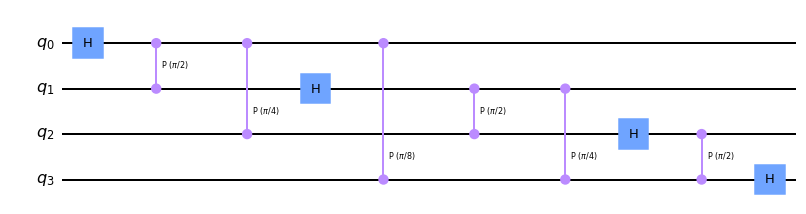

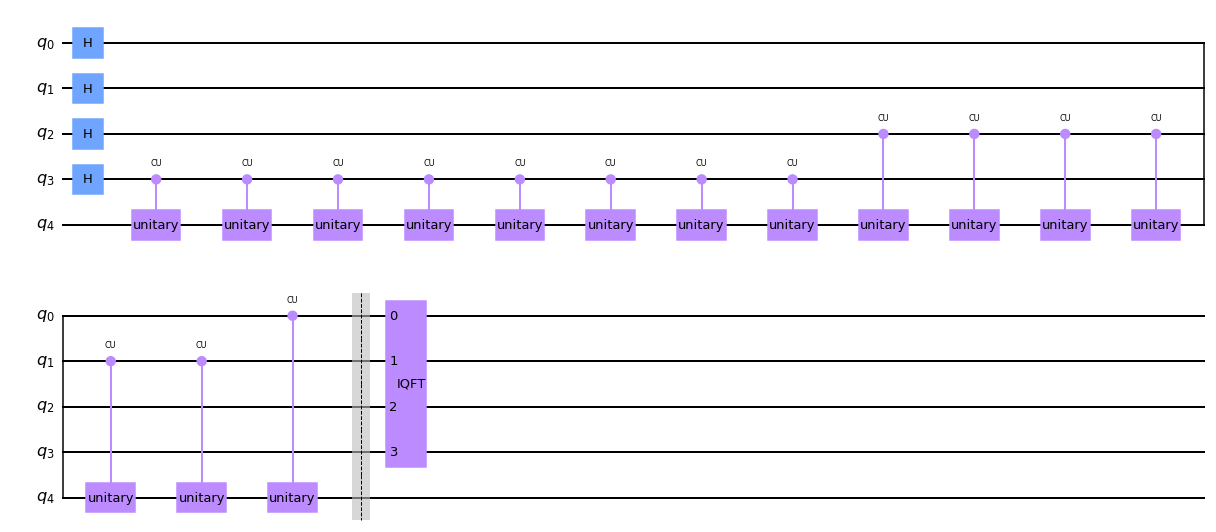

In [38]:
qpe_circ = QPE(precision=4,unitary=U).get_QPE(show=True)

## Attaching the circuit 

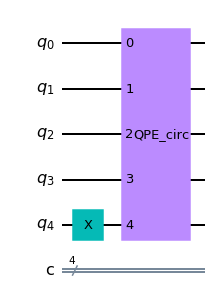

In [39]:
q = QuantumCircuit(5,4)
q.x(4)
q.append(qpe_circ,qargs = [0,1,2,3,4])
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

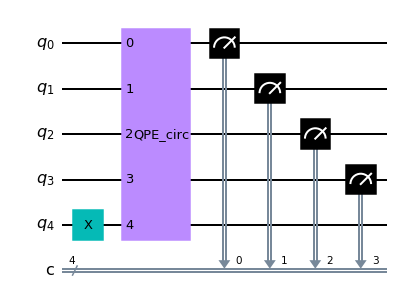

In [40]:
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

- **Visualizing and interpreting the results**

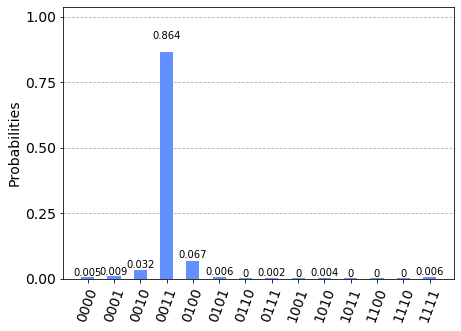

In [41]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)

- These high probability results are reasonably good estimates of the current qpe implementaion using arbitrary Unitary

## Testing 3 qubit circuit
- Using a 2 qubit CP gate with $\theta = \frac {1}{5} $ is used to estimate the phase of the 2 qubit unitary
- Again, the phase is represented upto 4 bit precision as : 
$$\theta = 0.0011$$

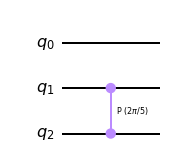

In [29]:
q = QuantumCircuit(3,name = 'Unitary')
q.cp(2*np.pi*(1/5),1,2)
q.draw('mpl')

Circuit for QFT of 4


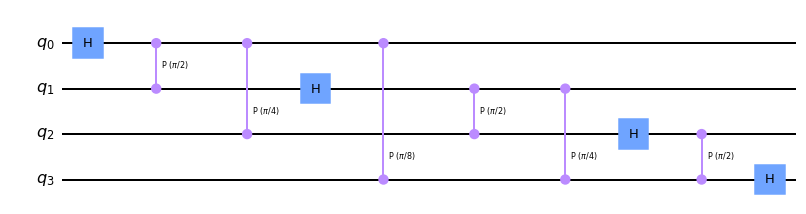

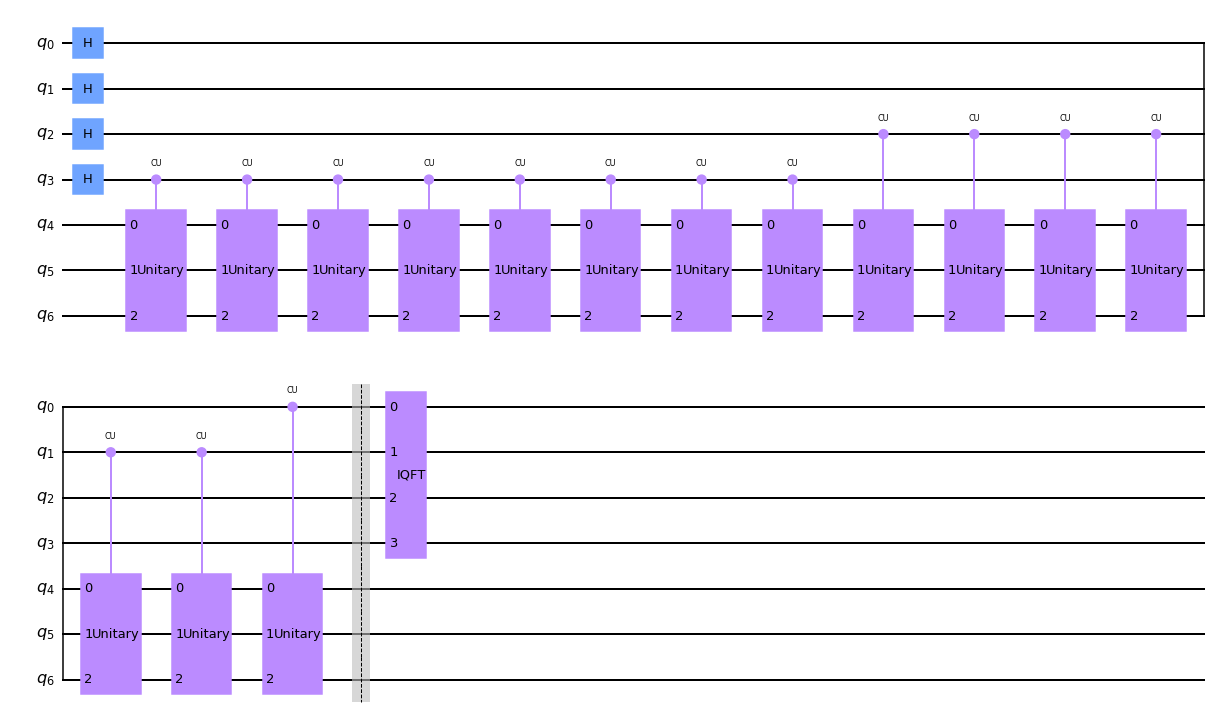

In [30]:
qpe_circ = QPE(precision=4,unitary=q).get_QPE(show=True)

## Attaching the Circuit
- Using the eigenvector $|011 \rangle$ to generate the phase kickback in the Quantum Circuit

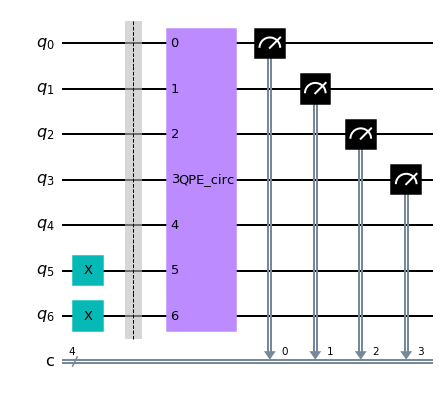

In [35]:
q = QuantumCircuit(7,4)
q.x([5,6])
q.barrier()
q.append(qpe_circ, qargs = [0,1,2,3,4,5,6])
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

- **Visualizing the Results**

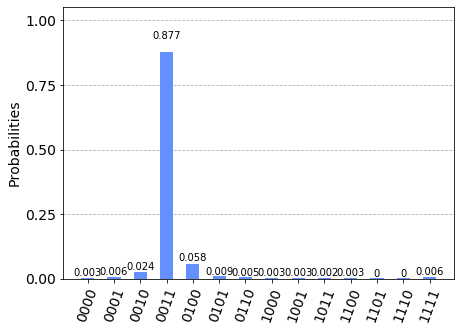

In [36]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)

## Arbitrary placement of Circuit
- Highlights the fact that the circuit can be placed as a sub-routine for an eigenvector in the current QuantumCircuit

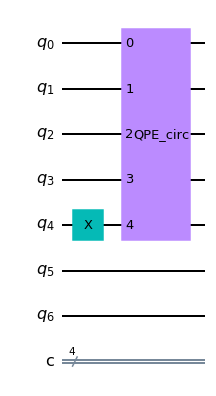

In [16]:
q = QuantumCircuit(7,4)
q.x(4)
q.append(qpe_circ,qargs = [0,1,2,3,4])
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

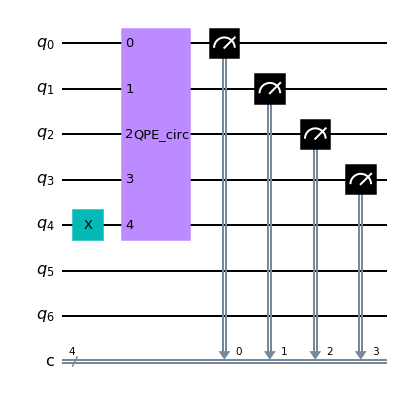

In [17]:
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

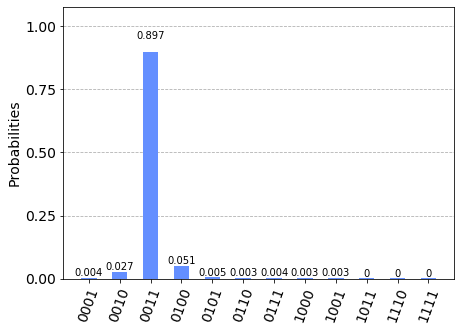

In [18]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)